# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217393

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            
            Train.best_acc = 0
            for epoch in range(1, (epochs+1)):
                #print("Step {} | Training Loss:".format(epoch), end = " " )
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:1})
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    #if(train_loss > 1e9):
                    
                    #print("{:.6f}".format(train_loss), end = ", " )
                    
                #print("")
                valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1})
                    
                
                accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})
                #print("*************** \n")
                print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                #print("*************** \n")
                #print("Accuracy on Test data: {}".format(accuracy))

                

                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    net.saver.save(sess, "dataset/tf_vae_only_vae_loss_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                    Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4]

    epochs = [50]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:50 hidden layers:2 features count:4
Step 1 | Training Loss: 0.002049 | Test Loss: 0.006900 | Test Accuracy: 0.762287
Step 2 | Training Loss: 0.000913 | Test Loss: 0.006516 | Test Accuracy: 0.783224
Step 3 | Training Loss: 0.000574 | Test Loss: 0.005305 | Test Accuracy: 0.774885
Step 4 | Training Loss: 0.000685 | Test Loss: 0.005682 | Test Accuracy: 0.775683
Step 5 | Training Loss: 0.000423 | Test Loss: 0.005936 | Test Accuracy: 0.779054
Step 6 | Training Loss: 0.000265 | Test Loss: 0.008684 | Test Accuracy: 0.728220
Step 7 | Training Loss: 0.000312 | Test Loss: 0.006923 | Test Accuracy: 0.767477
Step 8 | Training Loss: 0.000815 | Test Loss: 0.006486 | Test Accuracy: 0.766812
Step 9 | Training Loss: 0.000328 | Test Loss: 0.007451 | Test Accuracy: 0.752528
Step 10 | Training Loss: 0.000414 | Test Loss: 0.008112 | Test Accuracy: 0.765348
Step 11 | Training Loss: 0.000395 | Test Loss: 0.010227 | Test Accuracy: 0.731636
Step 12 | Training Loss: 0.000834 | T

Step 50 | Training Loss: 0.000390 | Test Loss: 0.009858 | Test Accuracy: 0.698856
Current Layer Attributes - epochs:50 hidden layers:2 features count:16
Step 1 | Training Loss: 0.001455 | Test Loss: 0.017737 | Test Accuracy: 0.783801
Step 2 | Training Loss: 0.001043 | Test Loss: 0.010940 | Test Accuracy: 0.811568
Step 3 | Training Loss: 0.002049 | Test Loss: 0.011264 | Test Accuracy: 0.835477
Step 4 | Training Loss: 0.000360 | Test Loss: 0.008973 | Test Accuracy: 0.786684
Step 5 | Training Loss: 0.000949 | Test Loss: 0.014045 | Test Accuracy: 0.806955
Step 6 | Training Loss: 0.000870 | Test Loss: 0.008680 | Test Accuracy: 0.779187
Step 7 | Training Loss: 0.002761 | Test Loss: 0.013877 | Test Accuracy: 0.835655
Step 8 | Training Loss: 0.001230 | Test Loss: 0.008530 | Test Accuracy: 0.812323
Step 9 | Training Loss: 0.000078 | Test Loss: 0.008805 | Test Accuracy: 0.781050
Step 10 | Training Loss: 0.003821 | Test Loss: 0.007726 | Test Accuracy: 0.796088
Step 11 | Training Loss: 0.000648 | 

Step 49 | Training Loss: 0.000290 | Test Loss: 0.007548 | Test Accuracy: 0.738911
Step 50 | Training Loss: 0.000163 | Test Loss: 0.007832 | Test Accuracy: 0.734874
Current Layer Attributes - epochs:50 hidden layers:4 features count:4
Step 1 | Training Loss: 0.002049 | Test Loss: 0.003780 | Test Accuracy: 0.786329
Step 2 | Training Loss: 0.001114 | Test Loss: 0.002870 | Test Accuracy: 0.776836
Step 3 | Training Loss: 0.000301 | Test Loss: 0.003780 | Test Accuracy: 0.729374
Step 4 | Training Loss: 0.000683 | Test Loss: 0.003420 | Test Accuracy: 0.818932
Step 5 | Training Loss: 0.000392 | Test Loss: 0.003944 | Test Accuracy: 0.852821
Step 6 | Training Loss: 0.000789 | Test Loss: 0.003064 | Test Accuracy: 0.834856
Step 7 | Training Loss: 0.000924 | Test Loss: 0.005637 | Test Accuracy: 0.659776
Step 8 | Training Loss: 0.000529 | Test Loss: 0.006301 | Test Accuracy: 0.670245
Step 9 | Training Loss: 0.000160 | Test Loss: 0.006024 | Test Accuracy: 0.645360
Step 10 | Training Loss: 0.000400 | T

Step 48 | Training Loss: 0.000149 | Test Loss: 0.004741 | Test Accuracy: 0.750133
Step 49 | Training Loss: 0.000159 | Test Loss: 0.004348 | Test Accuracy: 0.728442
Step 50 | Training Loss: 0.000088 | Test Loss: 0.004851 | Test Accuracy: 0.685016
Current Layer Attributes - epochs:50 hidden layers:4 features count:16
Step 1 | Training Loss: 0.000406 | Test Loss: 0.005080 | Test Accuracy: 0.786462
Step 2 | Training Loss: 0.000012 | Test Loss: 0.004697 | Test Accuracy: 0.814319
Step 3 | Training Loss: 0.000037 | Test Loss: 0.005162 | Test Accuracy: 0.836231
Step 4 | Training Loss: 0.000367 | Test Loss: 0.005833 | Test Accuracy: 0.749068
Step 5 | Training Loss: 0.000300 | Test Loss: 0.516254 | Test Accuracy: 0.784776
Step 6 | Training Loss: 0.000425 | Test Loss: 0.004624 | Test Accuracy: 0.787970
Step 7 | Training Loss: 0.001137 | Test Loss: 0.004218 | Test Accuracy: 0.795156
Step 8 | Training Loss: 0.000422 | Test Loss: 0.004489 | Test Accuracy: 0.780252
Step 9 | Training Loss: 0.000237 | 

Step 47 | Training Loss: 0.000045 | Test Loss: 0.002617 | Test Accuracy: 0.859475
Step 48 | Training Loss: 0.000634 | Test Loss: 0.002633 | Test Accuracy: 0.856946
Step 49 | Training Loss: 0.003376 | Test Loss: 0.007935 | Test Accuracy: 0.437101
Step 50 | Training Loss: 0.000531 | Test Loss: 0.004849 | Test Accuracy: 0.603797


In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
366,50,32,4,0.906731,0.889771
368,50,32,4,0.906890,0.887376
367,50,32,4,0.910859,0.886977
364,50,32,4,0.911811,0.882408
357,50,32,4,0.912050,0.873625
371,50,32,4,0.914828,0.873581
358,50,32,4,0.916812,0.872250
363,50,32,4,0.920067,0.869544
360,50,32,4,0.900778,0.868435
365,50,32,4,0.889268,0.867060


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8528  0.1472]
 [ 0.0614  0.9386]]


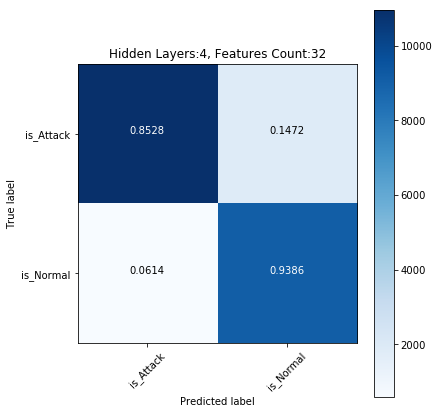

In [15]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)